In [1]:
import sys
sys.path.append('./tools')
sys.path.append('../tools')
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
import tensorflow as tf
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from smooth_tiled_predictions import predict_img_with_smooth_windowing
from segmentation_utils import plot_prediction

import segmentation_utils as su

TILE_SIZE = 512
DOWNSAMPLE = 10
NUM_CLASSES=6
BACKBONE = 'resnet34'

CLASSES = {0 : 'background',
           1 : 'Mucosa',
           2 : 'Linfocitos',
           3 : 'Submucosa',
           4 : 'Muscular',
           5 : 'Subserosa',
          }

2021-08-27 13:49:25.074839: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `keras` framework.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]='4' # Select the GPU 0

gpus = tf.config.list_physical_devices('GPU') # Use only the required GPU memory 
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu,True)

2021-08-27 13:49:32.556391: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-27 13:49:32.813332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2021-08-27 13:49:32.813429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-27 13:49:32.854122: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 13:49:32.854296: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-27 13:49:32.867107: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

In [10]:
def plot_merged(image, tissue, tumor, num_classes=6, cmap='viridis'):
    # Place all pixel values for colour coherence
    for j in range(num_classes):
        tissue[0,j]=j
        
    f = plt.figure(figsize = (15, 15))
    f.add_subplot(1,3,1)
    plt.axis('off')
    plt. title('Original image')
    plt.imshow(image)
    f.add_subplot(1,3,2)
    plt.axis('off')
    plt. title('Predicted tissues')
    plt.imshow(tissue, cmap=cmap)
    f.add_subplot(1,3,3)
    plt.axis('off')
    plt. title('Predicted tumor')
    plt.imshow(tumor, cmap='jet')
    
    f = plt.figure(figsize = (15, 15))
    f.add_subplot(1,1,1)
    plt.axis('off')
    plt. title('Tumor over Tissue')
    plt.imshow(image)
    no_background_tissue = np.ma.masked_where(tissue == 0, tissue) # remove background(0) from prediction
    no_background_tissue[0,0] = 0
    plt.imshow(no_background_tissue, cmap=cmap, alpha=0.85)
    no_background_tumor = np.ma.masked_where(tumor == 0, tumor) # remove background(0) from prediction
    no_background_tumor[0,0] = 0
    plt.imshow(no_background_tumor, cmap='jet', alpha=0.4)
    plt.show(block=True)
    plt.show

2021-08-27 13:49:33.088096: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-27 13:49:33.098038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2021-08-27 13:49:33.103735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2021-08-27 13:49:33.104268: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-27 13:49:35.078636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnec

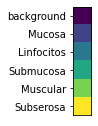

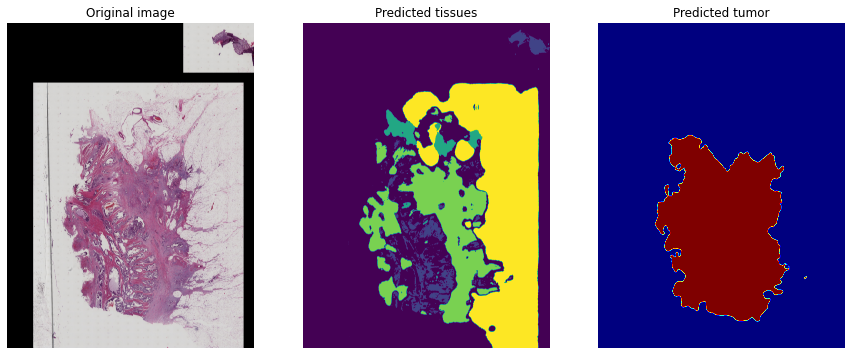

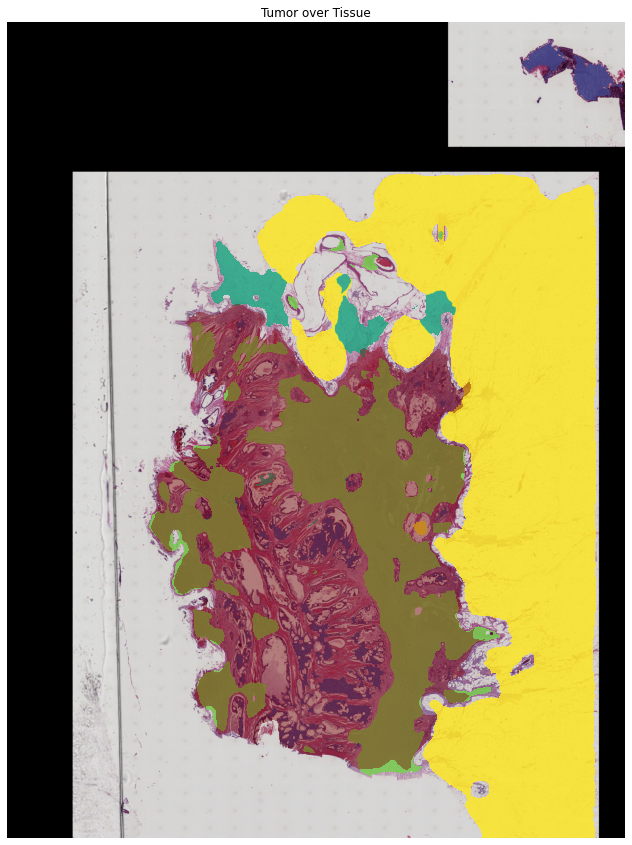

Tumor is invading tissues:
   Mucosa
   Submucosa
   Muscular
   Subserosa


In [4]:
############ LOAD MODELS ############
tissue_model = load_model('../tissue_segmentation/trained_models/'\
                          'tiled_unet_d'+str(DOWNSAMPLE)+'_t'+str(TILE_SIZE)+'my_loss.hdf5', compile=False)
       
#tumor_model = load_model('../tumor_segmentation/trained_models/'\
#                   'tiled_tumor_unet_d'+str(DOWNSAMPLE)+'_t'+str(TILE_SIZE)+'.hdf5', compile=False)
    
    
############ LOAD IMAGE TO PREDICT ############
img = cv2.imread('../tumor_segmentation/database/images/img/10-4095 HET.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # cv2 reads as BGR so must transform to RGB

def preprocess_data(img):
    scaler = MinMaxScaler()
    preprocess_input = sm.get_preprocessing(BACKBONE)
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape) # same as img = (img.astype('float32')) / 255.
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    return img
img = preprocess_data(img)
    
############ MAKE TISSUE PREDICTION ############
tissue_prediction = predict_img_with_smooth_windowing(
    img,
    window_size=TILE_SIZE,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=NUM_CLASSES,
    pred_func=(
        lambda img_batch_subdiv: tissue_model.predict((img_batch_subdiv))
    )
)
tissue = np.argmax(tissue_prediction, axis=2)
############ MAKE TUMOR PREDICTION ############
"""
tumor_prediction = predict_img_with_smooth_windowing(
    img,
    window_size=TILE_SIZE,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=NUM_CLASSES,
    pred_func=(
        lambda img_batch_subdiv: tumor_model.predict((img_batch_subdiv))
    )
)
tumor = np.argmax(tumor_prediction, axis=2)
"""
    # Read mask instead of predict 
tumor = cv2.imread('../tumor_segmentation/database/masks/img/10-4095 HET.png', 0)
tumor = np.where(tumor==59, 1, tumor) # Tumor=1 

############ PLOT PREDICTIONS ############
su.plot_legend(CLASSES)
plot_merged(img, tissue, tumor)

############ GET INVADED TISSUES ############
size = tissue.shape
tissues = set()
for i in range(size[0]):
    for j in range(size[1]):
        if tumor[i,j] == 1: tissues.add(tissue[i,j])
tissues.discard(0)   
print('Tumor is invading tissues:')
for tissue in tissues:
    print('  ',CLASSES.get(tissue,tissue))

/tmp/ipykernel_102160/3786830537.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  f.add_subplot(rows, columns, i)
/tmp/ipykernel_102160/3786830537.py:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  f.add_subplot(rows, columns, i)


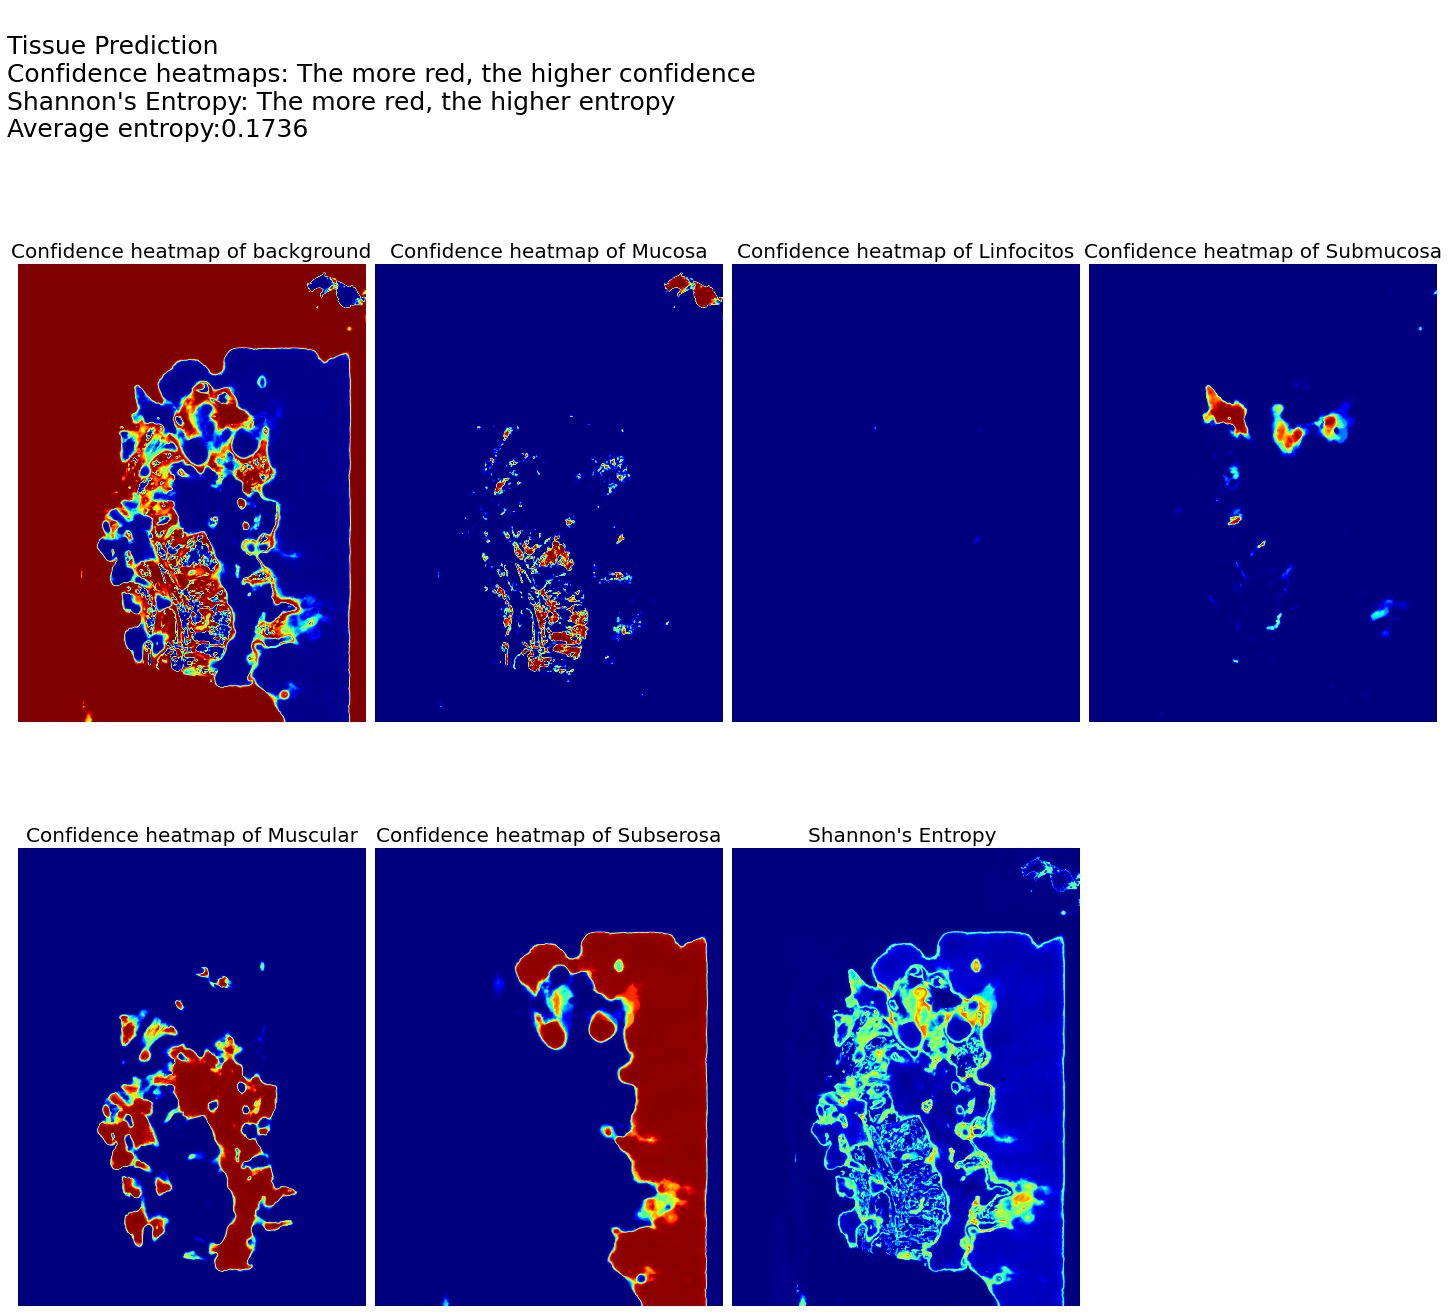

In [5]:
############ PLOT TISSUE CONFIDANCE AND ENTROPY ############
f = plt.figure(figsize = (20, 20))

shannon_entr = (-tissue_prediction*np.log2(tissue_prediction)).sum(axis=2)
shannon_entr=np.where(shannon_entr==np.nan, 0, shannon_entr) #mucosa=1      #backgroud=0

plt.suptitle('\nTissue Prediction' \
             '\nConfidence heatmaps: The more red, the higher confidence' \
             '\nShannon\'s Entropy: The more red, the higher entropy' \
             '\nAverage entropy:'+str(round(np.average(shannon_entr),4))+ \
             '\n', x=0, ha='left',fontsize=25)

columns = 4
rows = tissue_prediction.shape[2]/columns+1
i = 1


for channel in range(tissue_prediction.shape[2]):
    f.add_subplot(rows, columns, i)
    plt.title('Confidence heatmap of '+CLASSES[channel], fontsize=20)
    plt.axis('off')
    tissue_prediction[0,0,channel] = 0
    tissue_prediction[0,1,channel] = 1
    plt.imshow(tissue_prediction[:,:,channel], cmap='jet')
    i+=1
#https://stackoverflow.com/questions/33607071/fastest-way-to-compute-entropy-of-each-numpy-array-row
f.add_subplot(rows, columns, i)
plt.title('Shannon\'s Entropy ', fontsize=20)
plt.axis('off')
plt.imshow(shannon_entr, cmap='jet')
plt.tight_layout(w_pad=1, h_pad=1)

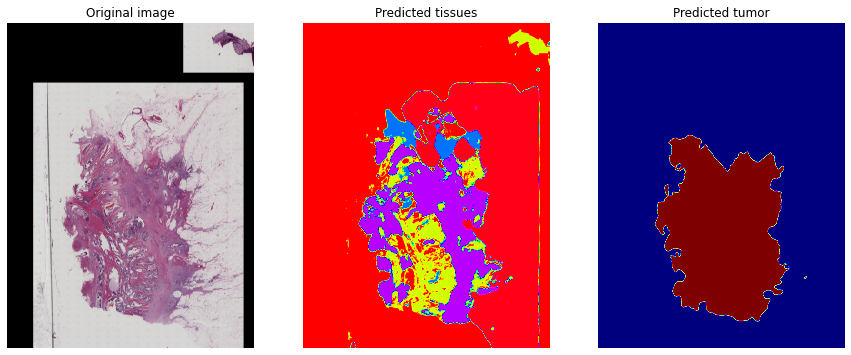

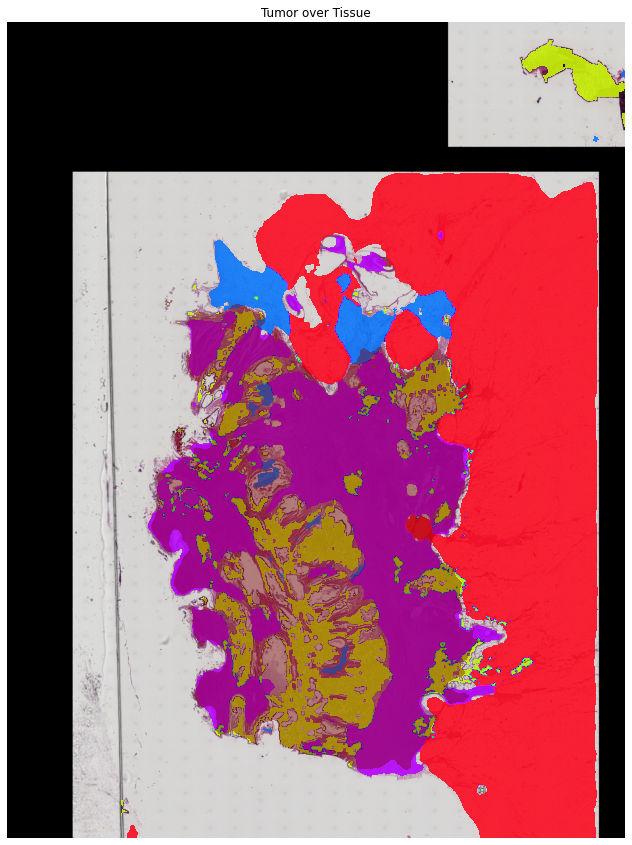

In [19]:
"""
CLASS_MULTIPLIER = {0 : 0.1,
                    1 : 1,
                    2 : 1,
                    3 : 1,
                    4 : 1,
                    5 : 1,
                   }

multiplied = tissue_prediction.copy()

for channel in range(multiplied.shape[2]):
    multiplied[:,:,channel] = multiplied[:,:,channel]*CLASS_MULTIPLIER[channel]
multiplied = np.argmax(multiplied, axis=2)
"""
plot_merged(img, multiplied, tumor, cmap='hsv')
